## Este algoritmo faz parte da PRAD Toolbox e foi desenvolvido pelo Laboratório de Geoprocessamento (ICAT/UFR) em parceria com o Laboratório de Geoprocessamento para Aplicações Ambientais (LabGIS/UFMS). O objetivo é dados que apoiem Projetos de Recuperação de Áreas Degradadas (PRAD), ampliando a integração entre sensoriamento remoto, geoprocessamento e comunicação visual.

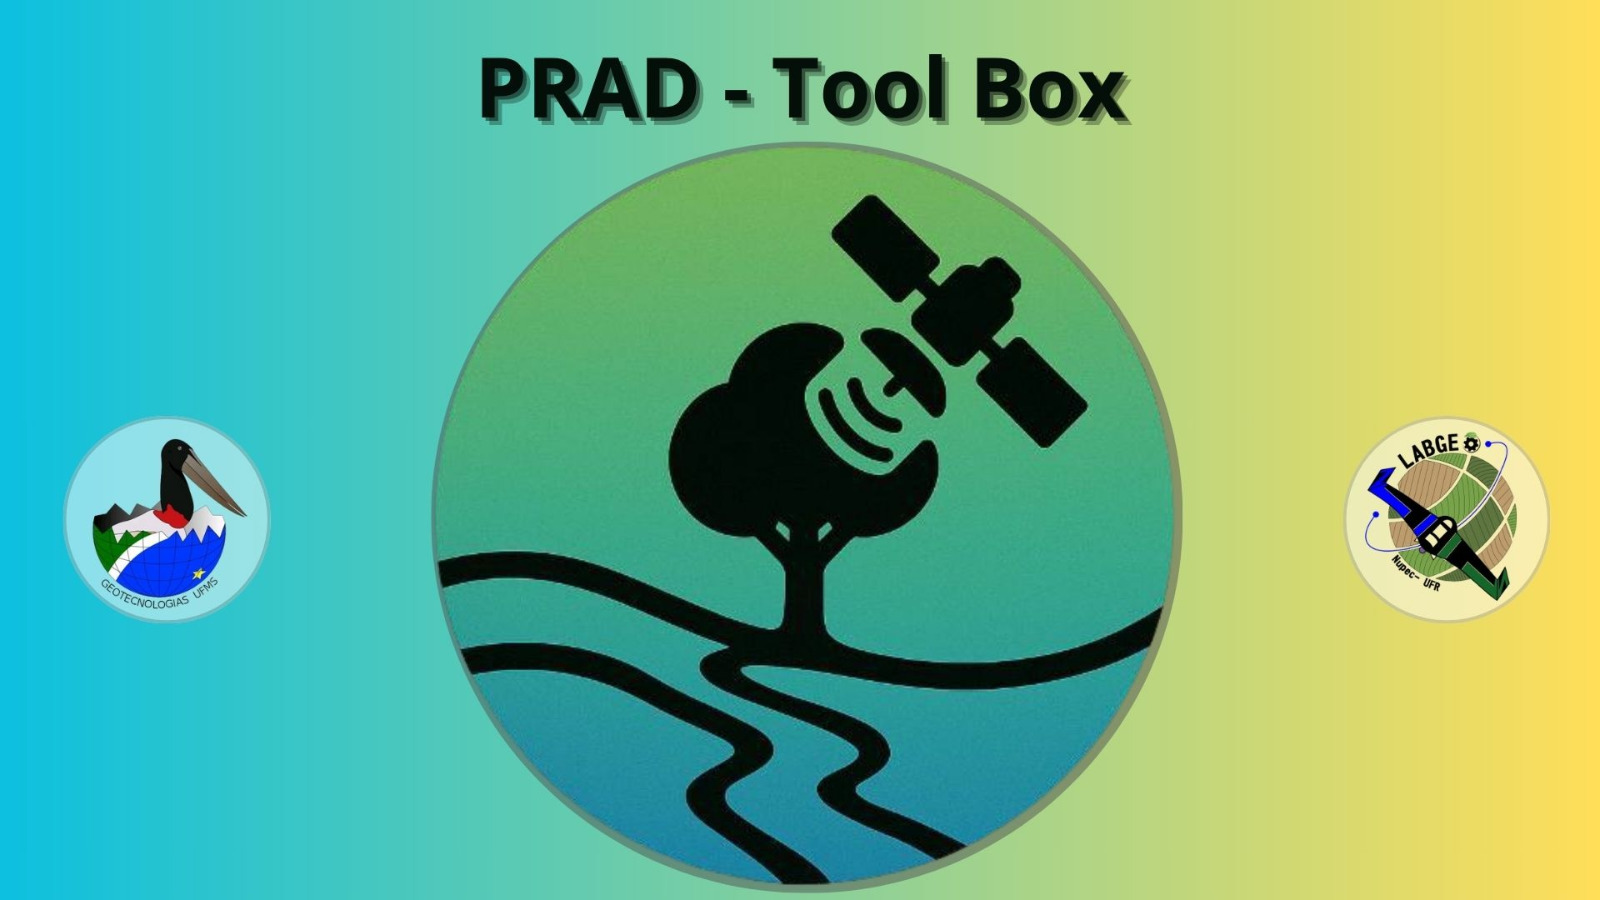


# ==========================================
# 1️⃣ Instalar dependências (se necessário)
# ==========================================
# Execute apenas uma vez

In [1]:
# @title
# ==========================================
# 1️⃣ Instalar dependências (se necessário)
# ==========================================
# Execute apenas uma vez
!pip install rasterio numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 44.8 MB/s eta 0:00:00


# ==========================================
# 2️⃣ Importar bibliotecas
# ==========================================

In [2]:
# @title
# ==========================================
# 2️⃣ Importar bibliotecas
# ==========================================
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
import os

# ==========================================
# 3️⃣ Upload do arquivo raster (ex: STRM_rec.tif)
# ==========================================

In [3]:
# @title
# ==========================================
# 3️⃣ Upload do arquivo raster (ex: STRM_rec.tif)
# ==========================================
print("Faça o upload do arquivo raster (*.tif)...")
uploaded = files.upload()

# Detecta o nome do arquivo enviado
raster_path = list(uploaded.keys())[0]
print(f"Arquivo carregado: {raster_path}")

Faça o upload do arquivo raster (*.tif)...


Saving DEM_30m_.tif to DEM_30m_.tif
Arquivo carregado: DEM_30m_.tif


# ==========================================
# 4️⃣ Abrir o raster e tratar valores NoData
# ==========================================

In [4]:
# @title
# ==========================================
# 4️⃣ Abrir o raster e tratar valores NoData
# ==========================================
with rasterio.open(raster_path) as src:
    altitude = src.read(1)  # primeira banda
    nodata = src.nodata

# Substituir NoData por NaN
if nodata is not None:
    altitude = np.where(altitude == nodata, np.nan, altitude)

# Calcular min e max ignorando NaN
min_altitude = np.nanmin(altitude)
max_altitude = np.nanmax(altitude)

print(f"Altitude mínima: {min_altitude:.2f}")
print(f"Altitude máxima: {max_altitude:.2f}")

Altitude mínima: 79.00
Altitude máxima: 1059.09


# ==========================================
# 5️⃣ Gerar eixos X e Y
# ==========================================

In [5]:
# @title
# ==========================================
# 5️⃣ Gerar eixos X e Y
# ==========================================
x = np.linspace(0, altitude.shape[1], altitude.shape[1])
y = np.linspace(0, altitude.shape[0], altitude.shape[0])
x, y = np.meshgrid(x, y)

In [6]:
# --- Parâmetros editáveis ---
# Janela de recorte (y0:y1, x0:x1). Use None para manter inteiro.
CROP = (150, 550, 200, 900)   # (y0, y1, x0, x1)
SMOOTH_SIGMA = 1.5            # 0 = sem suavização; 1–3 geralmente bom
Z_SCALE = 0.35                # <1 "achata" o relevo; >1 exagera

# --- Preparar dados conforme parâmetros ---
import numpy as np
try:
    from scipy.ndimage import gaussian_filter
except Exception:
    %pip -q install scipy
    from scipy.ndimage import gaussian_filter

alt_proc = altitude.copy()

# Suavização opcional
if SMOOTH_SIGMA and SMOOTH_SIGMA > 0:
    # preserva NaN durante o filtro
    mask = np.isnan(alt_proc)
    fill = np.nanmean(alt_proc)
    alt_f = alt_proc.copy()
    alt_f[mask] = fill
    alt_f = gaussian_filter(alt_f, sigma=SMOOTH_SIGMA)
    alt_f[mask] = np.nan
    alt_proc = alt_f

# Recorte opcional
if CROP is not None:
    y0, y1, x0, x1 = CROP
    alt_proc = alt_proc[y0:y1, x0:x1]
    x = np.linspace(x0, x1-1, alt_proc.shape[1])
    y = np.linspace(y0, y1-1, alt_proc.shape[0])
else:
    x = np.linspace(0, altitude.shape[1]-1, altitude.shape[1])
    y = np.linspace(0, altitude.shape[0]-1, altitude.shape[0])

x, y = np.meshgrid(x, y)

# Escala vertical
alt_proc_scaled = alt_proc * Z_SCALE

min_alt, max_alt = np.nanmin(alt_proc_scaled), np.nanmax(alt_proc_scaled)
print(f"Intervalo pós-processamento: min={min_alt:.2f}, max={max_alt:.2f}")

Intervalo pós-processamento: min=28.81, max=366.17


# ==========================================
# 6️⃣ Plotar superfície 3D com curvas de nível
# ==========================================

# ==========================================
# 7️⃣ Exportar figura 3D como PNG e baixar
# ==========================================

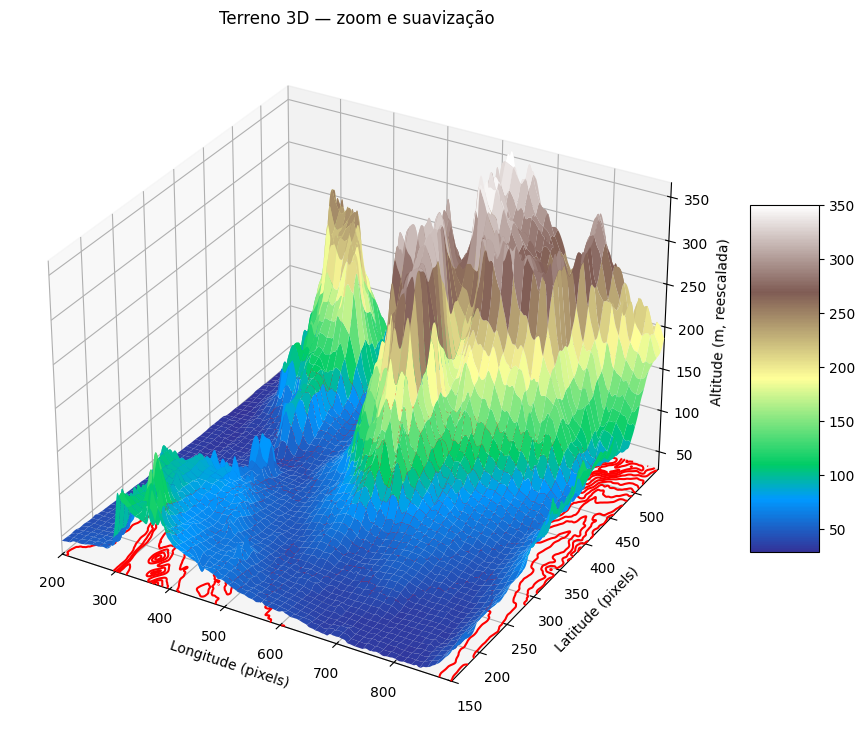

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, alt_proc_scaled, cmap='terrain', edgecolor='none')

levels = np.arange(np.nanmin(alt_proc_scaled), np.nanmax(alt_proc_scaled),
                   max((max_alt-min_alt)/20, 1))  # níveis adaptativos
ax.contour(x, y, alt_proc_scaled, levels=levels, colors='red',
           offset=np.nanmin(alt_proc_scaled))

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_title('Terreno 3D — zoom e suavização')
ax.set_xlabel('Longitude (pixels)')
ax.set_ylabel('Latitude (pixels)')
ax.set_zlabel('Altitude (m, reescalada)')

ax.set_zlim(np.nanmin(alt_proc_scaled), np.nanmax(alt_proc_scaled))
# Limites XY coerentes com o recorte
ax.set_xlim(np.nanmin(x), np.nanmax(x))
ax.set_ylim(np.nanmin(y), np.nanmax(y))

out_png = "visualizacao3D_terreno_zoom_suave.png"
plt.savefig(out_png, dpi=300, bbox_inches='tight')
plt.show()


In [10]:
# ==========================================
# 7️⃣ Exportar figura 3D como PNG e baixar
# ==========================================
output_path = "visualizacao3D_terreno.png"

# Recria o gráfico (necessário para salvar corretamente)
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Use the processed and scaled altitude data and the cropped x and y arrays
surf = ax.plot_surface(x, y, alt_proc_scaled, cmap='terrain', edgecolor='none')

# Use the min and max values of the processed and scaled altitude for contour levels and z-limits
min_alt_proc = np.nanmin(alt_proc_scaled)
max_alt_proc = np.nanmax(alt_proc_scaled)
levels = np.arange(min_alt_proc, max_alt_proc, max((max_alt_proc-min_alt_proc)/20, 1))
ax.contour(x, y, alt_proc_scaled, levels=levels, colors='red', offset=min_alt_proc)

ax.set_title('Visualização 3D do Terreno com Curvas de Nível (Recortado e Suavizado)')
ax.set_xlabel('Longitude (pixels)')
ax.set_ylabel('Latitude (pixels)')
ax.set_zlabel('Altitude (m, reescalada)')

ax.set_zlim(min_alt_proc, max_alt_proc)
# Use the min and max values of the cropped x and y arrays for x and y limits
ax.set_xlim(np.nanmin(x), np.nanmax(x))
ax.set_ylim(np.nanmin(y), np.nanmax(y))


plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"💾 Figura salva como: {output_path}")
files.download(output_path)

💾 Figura salva como: visualizacao3D_terreno.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>